This notebook serves to do some manual feature engineering for our SVM, before we do deeper neural networks. I also write down a shallower neural net that will generate features via machine learning; these features can be used as the inputs to the SVM.

*Features*:
- Fourier/DCT Transform
- Wavelets
- PCA 
- Neural net features

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
import os
import glob
import tqdm
import pywt

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

from scipy import signal
from sklearn.decomposition import PCA

In [2]:
# load in data
train_path = "../../project-data/train_another/"
val_path = "../../project-data/validation_another/"
test_path = "../../project-data/test_another/"
img_size = 128
nchannels = 3

npz_file_listing_train = list(glob.glob(os.path.join(train_path, '**/*.npz')))
npz_file_listing_val = list(glob.glob(os.path.join(val_path, '**/*.npz')))
npz_file_listing_test = list(glob.glob(os.path.join(test_path, '**/*.npz')))
N_train = len(npz_file_listing_train)
N_val = len(npz_file_listing_val)
N_test = len(npz_file_listing_test)

training_data_X = np.zeros((N_train, img_size, img_size, nchannels))
training_data_y = np.zeros(N_train)
val_data_X = np.zeros((N_val, img_size, img_size, nchannels))
val_data_y = np.zeros(N_val)
test_data_X = np.zeros((N_test, img_size, img_size, nchannels))
test_data_y = np.zeros(N_test)

it = 0
for npz_file in tqdm.tqdm(npz_file_listing_train):
    training_data_X[it, :, :, :] = np.load(npz_file)['pixels']
    if "no_" in npz_file:
        training_data_y[it] = 0
    else:
        training_data_y[it] = 1
    it += 1
    
# it = 0
# for npz_file in tqdm.tqdm(npz_file_listing_val):
#     val_data_X[it, :, :, :] = np.load(npz_file)['pixels']
#     if "no_" in npz_file:
#         val_data_y[it] = 0
#     else:
#         val_data_y[it] = 1
#     it += 1
    
# it = 0
# for npz_file in tqdm.tqdm(npz_file_listing_test):
#     test_data_X[it, :, :, :] = np.load(npz_file)['pixels']
#     if "no_" in npz_file:
#         test_data_y[it] = 0
#     else:
#         test_data_y[it] = 1
#     it += 1

rand_idx = np.random.randint(0, N_train, size=2000)
train_X_sample = training_data_X[rand_idx, :]
train_y_sample = training_data_y[rand_idx]
N_train = 2000

100%|██████████| 10000/10000 [00:34<00:00, 288.54it/s]


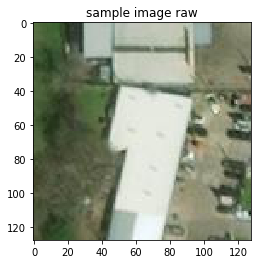

In [3]:
# plot sample image
plt.imshow(train_X_sample[0, :,:,:]/255)
plt.title("sample image raw")
plt.show()

100%|██████████| 2000/2000 [00:03<00:00, 627.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


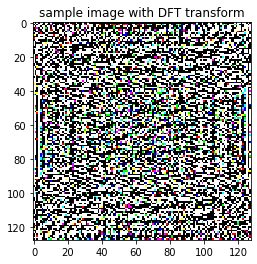

In [4]:
# Fourier transform
train_X_sample_dft = np.zeros(train_X_sample.shape)
for image in tqdm.tqdm(range(N_train)):
    for channel in range(nchannels):
        train_X_sample_dft[image, :, :, channel] = np.real(np.fft.fft2(train_X_sample[image, :, :, channel]))
        
plt.imshow(train_X_sample_dft[0, :,:,:])
plt.title("sample image with DFT transform")
plt.show()

100%|██████████| 2000/2000 [00:04<00:00, 440.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


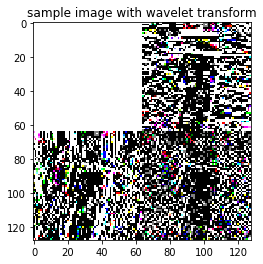

In [5]:
# wavelets
train_X_sample_dwt = np.zeros(train_X_sample.shape)
for image in tqdm.tqdm(range(N_train)):
    for channel in range(nchannels):
        coeffs = pywt.dwt2(train_X_sample[image, :, :, channel], 'haar')
        LL, (LH, HL, HH) = coeffs
        train_X_sample_dwt[image, :, :, channel] = np.block([[LL, LH], [HL, HH]])
        
plt.imshow(train_X_sample_dwt[0, :,:,:])
plt.title("sample image with wavelet transform")
plt.show()

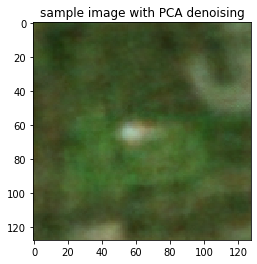

In [8]:
# pca
train_X_sample_red = train_X_sample[:,:,:,0].reshape(N_train, img_size * img_size)
train_X_sample_green = train_X_sample[:,:,:,1].reshape(N_train, img_size * img_size)
train_X_sample_blue = train_X_sample[:,:,:,2].reshape(N_train, img_size * img_size)

train_pca_red = PCA(n_components=0.9)
train_pca_red.fit(train_X_sample_red)
train_pca_green = PCA(n_components=0.9)
train_pca_green.fit(train_X_sample_green)
train_pca_blue = PCA(n_components=0.9)
train_pca_blue.fit(train_X_sample_blue)

red_components = train_pca_red.transform(train_X_sample_red)
green_components = train_pca_green.transform(train_X_sample_green)
blue_components = train_pca_blue.transform(train_X_sample_blue)

projected_red = train_pca_red.inverse_transform(red_components)
projected_green = train_pca_green.inverse_transform(green_components)
projected_blue = train_pca_blue.inverse_transform(blue_components)

out = np.zeros(train_X_sample.shape)
out[:,:,:,0] = projected_red.reshape(N_train, img_size, img_size)
out[:,:,:,1] = projected_green.reshape(N_train, img_size, img_size)
out[:,:,:,2] = projected_blue.reshape(N_train, img_size, img_size)

plt.imshow(out[0,:,:,:]/255)
plt.title("sample image with PCA denoising")
plt.show()

In [5]:
# test out utils file
import features_util

#util_dft_X = features_util.dft_features(train_X_sample)
#plt.imshow(util_dft_X[0,:,:,:])
#plt.show()

util_pca = features_util.pca_features(train_X_sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


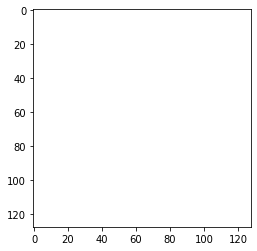

In [6]:
uti

In [90]:
model_conv

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (5): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (bra